### Libraries

In [31]:
import os
import holidays
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from ta.momentum import RSIIndicator
import plotly.graph_objects as go

from ta import add_all_ta_features


### Functions

In [18]:
def plot_acf_pacf(model, lags=365):
    fig = plt.figure(figsize=[25,10])
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(model.resid.values.squeeze(), lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(model.resid.values.squeeze(), lags=lags, ax=ax2)

In [19]:
def draw_arima_forecast(ts, arima_model, start_dt=0, end_dt=-1):
  predict = arima_model.get_prediction()
  forecast = pd.DataFrame(predict.predicted_mean).rename(columns = {'predicted_mean':'static_forecast'})
  forecast_ci = predict.conf_int().rename(columns = {'lower wage_boxcox':'l_ci_st',	'upper wage_boxcox':'u_ci_st'}) 

  predict_dy = arima_model.get_prediction(dynamic=start_dt)
  forecast_dy = pd.DataFrame(predict_dy.predicted_mean).rename(columns = {'predicted_mean':'dynamic_forecast'})
  forecast_dy_ci = predict_dy.conf_int().rename(columns = {'lower wage_boxcox':'l_ci_dy',	'upper wage_boxcox':'u_ci_dy'}) 

  if start_dt ==0:
    start_dt= ts.index.min()

  if end_dt == -1:
    end_dt = ts.index.max()

  fig = ts.loc[start_dt:].merge(
      forecast[start_dt:end_dt],
        how = 'left', left_index = True, right_index = True
        ).merge(
            forecast_dy[start_dt:],
            how = 'left', left_index = True, right_index = True
        ).merge(
          forecast_ci,
          how = 'left', left_index = True, right_index = True
        ).merge(
          forecast_dy_ci,
          how = 'left', left_index = True, right_index = True
        ).plot().update_layout(height=350, width=1300).show()

  return fig

### Read data

In [20]:
folder_path = './data/'
files = os.listdir(folder_path)
print(files)

list_to_concat = []
for file in files:
    if 'txt' in file:
        list_to_concat.append(pd.read_csv(f'./data/{file}', sep=','))


['AFKS_daily_010114_010124.csv', 'AFKS_daily_010114_010124.txt']


### Preprocessing

In [21]:
def column_name_preprocesing(df):
    '''
    change names of columns
    drop columns
    add change in price column
    '''
    df = df.copy()
    df.rename(columns={'<OPEN>': 'open', '<HIGH>': 'high', '<LOW>': 'low', '<CLOSE>': 'close', '<VOL>': 'volume', '<TICKER>':'symbol','<DATE>':'datetime'}, inplace=True)
    columns_to_keep = ['symbol', 'datetime', 'open', 'close', 'high', 'low', 'volume']
    df = df[columns_to_keep]
    df.sort_values(by = ['symbol','datetime'], inplace = True)
    # df['change_in_price'] = df['close'].diff()
    return df

In [48]:
result = pd.concat(list_to_concat, ignore_index=True)
result = column_name_preprocesing(result)
result['datetime'] = pd.to_datetime(result['datetime'], format='%Y%m%d')
df = result
date_range = pd.date_range(start=df['datetime'].min(), end=df['datetime'].max(), freq='D')
df = pd.DataFrame(date_range, columns=['datetime']).merge(df, how='left', on='datetime')
df = df.fillna(method='ffill')
df['rsi14'] = ((RSIIndicator(close = df['close'], window = 14).rsi() - 50)/50)
df['rsi30'] = ((RSIIndicator(close = df['close'], window = 14).rsi() - 50)/50)

df = add_all_ta_features(
    df, open="open", high="high", low="low", close="close", volume="volume", fillna=True)


C:\Users\Matvey\AppData\Local\Temp\ipykernel_32384\4192548592.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


In [49]:
df['datetime'] = df['datetime'].shift(-1)
df['close'] = df['close'].shift(-1)

df = df.set_index('datetime')
df.drop(columns=['symbol','open','high','low'], inplace=True)
df.dropna(inplace=True)



### SARIMAX

In [54]:
# split_idx = int(len(df) * 0.9)
split_idx = -100
ts1 = df.iloc[:split_idx]
ts2 = df.iloc[split_idx:]

C:\Users\Matvey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Matvey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Matvey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\Matvey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespac

6283.488143981742 6894.027893637524 6501.3099224707785
                                            SARIMAX Results                                            
Dep. Variable:                                           close   No. Observations:                 3531
Model:             SARIMAX(1, 1, 1)x(2, 1, [1, 2, 3, 4, 5], 7)   Log Likelihood               -3042.744
Date:                                         Thu, 29 Feb 2024   AIC                           6283.488
Time:                                                 17:30:19   BIC                           6894.028
Sample:                                             01-20-2014   HQIC                          6501.310
                                                  - 09-20-2023                                         
Covariance Type:                                           opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------

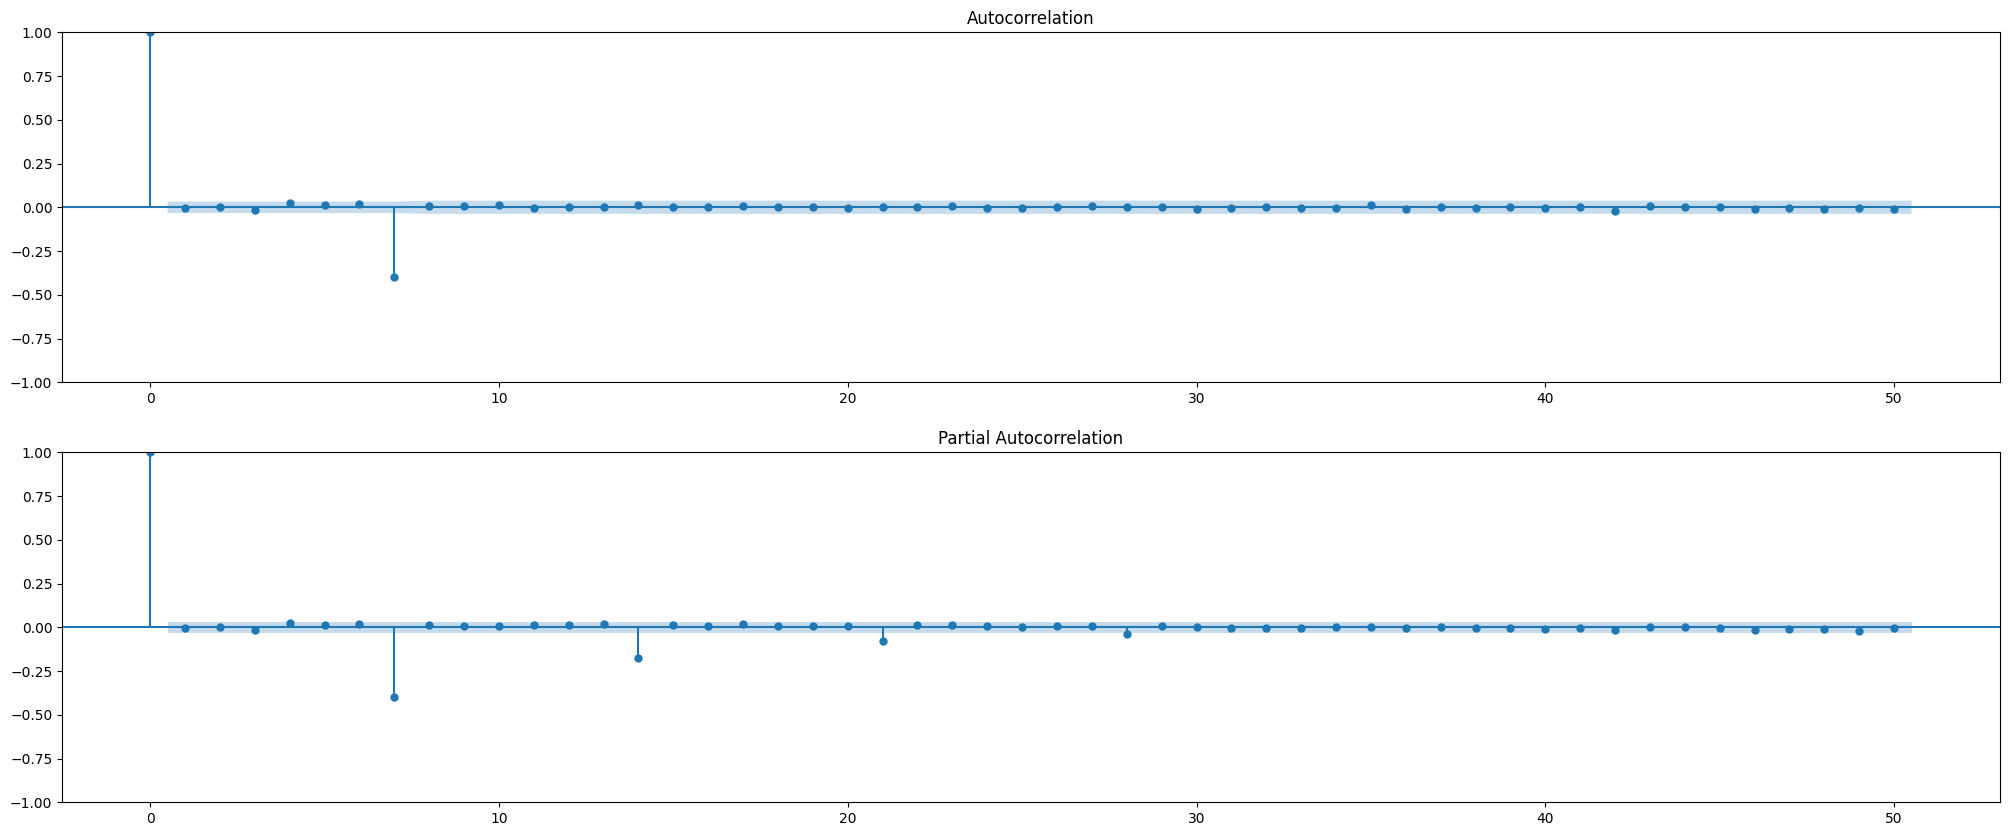

In [55]:
arima_best = sm.tsa.SARIMAX(endog=ts1['close'], order=[1,1,1], seasonal_order=[2,1,5,7],exog = ts1[df.columns.difference(['close'])]).fit()
print(arima_best.aic, arima_best.bic, arima_best.hqic)
print(arima_best.summary())
plot_acf_pacf(arima_best, lags=50)

### Results

-100

In [56]:
ts_frc = arima_best.forecast(steps=len(ts2), exog = ts2[df.columns.difference(['close'])])

fig = go.Figure()

fig.add_trace(go.Scatter(x=df.index,
                        y=df['close']
                        , name="true"))
fig.add_trace(go.Scatter(x=ts2.index,
                        y=ts_frc
                        , name="predict"))
 
fig.update_layout(height=500, width=1000).show()

-29

In [53]:
ts_frc = arima_best.forecast(steps=len(ts2), exog = ts2[df.columns.difference(['close'])])

fig = go.Figure()

fig.add_trace(go.Scatter(x=df.index,
                        y=df['close']
                        , name="true"))
fig.add_trace(go.Scatter(x=ts2.index,
                        y=ts_frc
                        , name="predict"))
 
fig.update_layout(height=500, width=1000).show()